# 5장_우리나라_인구_소멸_위기_지역_분석

이번 절에서는 대한민국 지도를 그리고 그 위에 인구 소멸 위기 지역에 대해 매핑해서 시각화하는 것을 최종 목표로 합니다.

In [2]:
import sys
import numpy as np
import pandas as pd
import time
import json
import re

# A Fast, Extensible Progress Bar for Python and CLI
from tqdm import tqdm

# Statistical data visualization using matplotlib.
import seaborn as sns

# Python Data. Leaflet.js Maps.
import folium

# matplotlib: plotting with Python.
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager

# Set the matplotlib color cycle using a seaborn palette.
sns.set_palette('pastel')

# plot outputs appear and be stored within the notebook.
%matplotlib inline

# A module for finding, managing, and using fonts across platforms.
mpl.font_manager._rebuild()
sorted([f.name for f in mpl.font_manager.fontManager.ttflist if f.name.startswith('Malgun')])

mpl.rc('axes', unicode_minus=False)

if sys.platform.startswith('darwin'):
    mpl.rc('font', family='AppleGothic')
elif sys.platform.startswith('win32'):
    mpl.rc('font', family='Malgun Gothic')

# An importlib package installable from any python version
import importlib
import modules.fs as fs
import modules.juso as juso
import modules.kakao.map as kakao

## 5-1 목표 명확히 하기

이상호 한국고용정보원 연구원의 <한국의 지방소멸에 관한 7가지 분석>이라는 보고서에서 사용한 방법으로, **인구 소멸 지역의 정의를 65세 이상 노인 인구와 20~39세 여성 인구를 비교해서 젊은 여성 인구가 노인 인구의 절반에 미달한 경우 인구 소멸 위험 지역으로 분류하는 방법** 입니다.

이 방식에 따라 먼저 각 지역별 20~30대 여성 인구수를 파악해야 하며, 또 65세 이상 노인 인구수를 파악해야 합니다. 또한 인구 소멸 위기 지역인지 파악해야 합니다. 그리고 한 단계 더 나아가 한국 지도에 시각화하기 위해 한국 지도를 그리는 법을 확보해야 합니다.

## 5-2 인구 데이터 확보하고 정리하기

In [3]:
df = pd.read_csv('./data/성별, 연령별 인구 - 시군구(2019).csv', encoding='euc-kr')
df.head()

광역시도   시군구  행정구  구분       합계   15세미만  15~19세  20~24세  25~29세  30~34세  ...  \
0   서울    소계  NaN   계  9096901  983091  402343  548245  768413  687804  ...   
1   서울    소계  NaN  남자  4386287  505543  201751  233761  377349  341858  ...   
2   서울    소계  NaN  여자  4710614  477548  200592  314484  391064  345946  ...   
3   서울   종로구  NaN   계   136649   12204    5801    9816   11972    9459  ...   
4   서울   종로구  NaN  남자    65594    6183    2803    4230    6167    4747  ...   

   40~44세  45~49세  50~54세  55~59세  60~64세  65~69세  70~74세  75~79세  80~84세  \
0  677660  782455  731258  728273  664875  465250  370242  280007  163363   
1  335606  385491  354886  349208  313417  218378  170303  126711   66754   
2  342054  396964  376372  379065  351458  246872  199939  153296   96609   
3    9034   11784   11462   11781   10125    7057    5960    5277    3341   
4    4341    5709    5511    5773    5021    3369    2659    2290    1387   

   85세이상  
0  96792  
1  30757  
2  66035  
3   2065  
4    747  

[5 rows x 21 columns]

In [4]:
df['시군구'][df['행정구'].notnull()] = df['행정구'][df['행정구'].notnull()]
df = df[df['시군구'] != '소계']
df.head()

광역시도   시군구  행정구  구분      합계  15세미만  15~19세  20~24세  25~29세  30~34세  ...  \
3   서울   종로구  NaN   계  136649  12204    5801    9816   11972    9459  ...   
4   서울   종로구  NaN  남자   65594   6183    2803    4230    6167    4747  ...   
5   서울   종로구  NaN  여자   71055   6021    2998    5586    5805    4712  ...   
6   서울    중구  NaN   계  115665   9839    3896    7511   10304    9636  ...   
7   서울    중구  NaN  남자   55820   4988    1896    3103    5115    4790  ...   

   40~44세  45~49세  50~54세  55~59세  60~64세  65~69세  70~74세  75~79세  80~84세  \
3    9034   11784   11462   11781   10125    7057    5960    5277    3341   
4    4341    5709    5511    5773    5021    3369    2659    2290    1387   
5    4693    6075    5951    6008    5104    3688    3301    2987    1954   
6    7836    8903    9313    9786    9002    6211    5077    4201    2581   
7    4054    4423    4587    4830    4430    2998    2295    1795    1003   

   85세이상  
3   2065  
4    747  
5   1318  
6   1695  
7    523  

[5 rows x 21 columns]

## 5-3 인구 소멸 위기 지역 계산하고 데이터 정리하기

인구 소멸 위기 지역을 알기 위해서는 먼저 20-30대의 인구를 알아야 합니다. 그리고 65세 이상 인구수도 알아야 합니다.

In [5]:
df['20~39세'] = df['20~24세'] + df['25~29세'] + df['30~34세'] + df['35~39세']
df['65세이상'] = df['65~69세'] + df['70~74세'] + df['75~79세'] + df['80~84세'] + df['85세이상']
df['시군구'] = [s[1:] for s in df['시군구'].values]
df.rename(columns={'합계':'인구수'}, inplace=True)
df.head()

광역시도  시군구  행정구  구분     인구수  15세미만  15~19세  20~24세  25~29세  30~34세  ...  \
3   서울  종로구  NaN   계  136649  12204    5801    9816   11972    9459  ...   
4   서울  종로구  NaN  남자   65594   6183    2803    4230    6167    4747  ...   
5   서울  종로구  NaN  여자   71055   6021    2998    5586    5805    4712  ...   
6   서울   중구  NaN   계  115665   9839    3896    7511   10304    9636  ...   
7   서울   중구  NaN  남자   55820   4988    1896    3103    5115    4790  ...   

   50~54세  55~59세  60~64세  65~69세  70~74세  75~79세  80~84세  85세이상  20~39세  \
3   11462   11781   10125    7057    5960    5277    3341   2065   40758   
4    5511    5773    5021    3369    2659    2290    1387    747   19801   
5    5951    6008    5104    3688    3301    2987    1954   1318   20957   
6    9313    9786    9002    6211    5077    4201    2581   1695   37325   
7    4587    4830    4430    2998    2295    1795    1003    523   17998   

   65세이상  
3  23700  
4  10452  
5  13248  
6  19765  
7   8614  

[5 rows x 23 columns]

In [6]:
pop = pd.pivot_table(df, 
                     index=['광역시도', '시군구'],
                     columns=['구분'],
                     values=['인구수', '20~39세', '65세이상'])
pop.head()

20~39세                65세이상                   인구수                
구분            계     남자     여자      계     남자     여자       계      남자      여자
광역시도 시군구                                                                  
강원   강릉시  46008  25015  20993  40497  17378  23119  203057  101154  101903
     고성군   4006   2307   1699   7005   2957   4048   23621   11933   11688
     동해시  16311   8801   7510  16152   7075   9077   83888   42093   41795
     삼척시  12428   7148   5280  14953   6314   8639   61833   31630   30203
     속초시  15928   8517   7411  14010   5866   8144   76302   37488   38814

In [8]:
pop['소멸비율'] = pop['20~39세','여자'] / (pop['65세이상','계'] / 2)
pop.head()

20~39세                65세이상                   인구수                  \
구분            계     남자     여자      계     남자     여자       계      남자      여자   
광역시도 시군구                                                                     
강원   강릉시  46008  25015  20993  40497  17378  23119  203057  101154  101903   
     고성군   4006   2307   1699   7005   2957   4048   23621   11933   11688   
     동해시  16311   8801   7510  16152   7075   9077   83888   42093   41795   
     삼척시  12428   7148   5280  14953   6314   8639   61833   31630   30203   
     속초시  15928   8517   7411  14010   5866   8144   76302   37488   38814   

              소멸비율  
구분                  
광역시도 시군구            
강원   강릉시  1.036768  
     고성군  0.485082  
     동해시  0.929916  
     삼척시  0.706213  
     속초시  1.057959

In [9]:
pop['소멸위기지역'] = pop['소멸비율'] < 1.0
pop.head()

20~39세                65세이상                   인구수                  \
구분            계     남자     여자      계     남자     여자       계      남자      여자   
광역시도 시군구                                                                     
강원   강릉시  46008  25015  20993  40497  17378  23119  203057  101154  101903   
     고성군   4006   2307   1699   7005   2957   4048   23621   11933   11688   
     동해시  16311   8801   7510  16152   7075   9077   83888   42093   41795   
     삼척시  12428   7148   5280  14953   6314   8639   61833   31630   30203   
     속초시  15928   8517   7411  14010   5866   8144   76302   37488   38814   

              소멸비율 소멸위기지역  
구분                         
광역시도 시군구                   
강원   강릉시  1.036768  False  
     고성군  0.485082   True  
     동해시  0.929916   True  
     삼척시  0.706213   True  
     속초시  1.057959  False

소멸비율이 1 이하면 소멸위기지역이라고 기록합니다. 총 99개 지자체 입니다.

In [10]:
pop[pop['소멸위기지역']].index.get_level_values(1)

Index(['고성군', '동해시', '삼척시', '양구군', '양양군', '영월군', '인제군', '정선군', '철원군', '태백시',
       '평창군', '홍천군', '화천군', '횡성군', '가평군', '양평군', '여주시', '연천군', '거창군', '고성군',
       '남해군', '밀양시', '사천시', '산청군', '의령군', '창녕군', '하동군', '함안군', '함양군', '합천군',
       '경주시', '고령군', '군위군', '김천시', '문경시', '봉화군', '상주시', '성주군', '안동시', '영덕군',
       '영양군', '영주시', '영천시', '예천군', '울릉군', '울진군', '의성군', '청도군', '청송군', '동구',
       '영도구', '중구', '강화군', '옹진군', '강진군', '고흥군', '곡성군', '구례군', '담양군', '보성군',
       '신안군', '영광군', '영암군', '완도군', '장성군', '장흥군', '진도군', '함평군', '해남군', '화순군',
       '고창군', '김제시', '남원시', '무주군', '부안군', '순창군', '완주군', '임실군', '장수군', '정읍시',
       '진안군', '공주시', '금산군', '논산시', '보령시', '부여군', '서천군', '예산군', '청양군', '태안군',
       '홍성군', '괴산군', '단양군', '보은군', '영동군', '옥천군', '제천시'],
      dtype='object', name='시군구')

In [11]:
len(pop[pop['소멸위기지역']].index.get_level_values(1))

97

In [12]:
pop.columns.get_level_values(0)

Index(['20~39세', '20~39세', '20~39세', '65세이상', '65세이상', '65세이상', '인구수', '인구수',
       '인구수', '소멸비율', '소멸위기지역'],
      dtype='object')

In [13]:
tmp_col = [pop.columns.get_level_values(0)[i] + \
           pop.columns.get_level_values(1)[i]
           for i in range(len(pop.columns.get_level_values(0)))]
pop.columns = tmp_col
pop.head()

20~39세계  20~39세남자  20~39세여자  65세이상계  65세이상남자  65세이상여자    인구수계  \
광역시도 시군구                                                                  
강원   강릉시    46008     25015     20993   40497    17378    23119  203057   
     고성군     4006      2307      1699    7005     2957     4048   23621   
     동해시    16311      8801      7510   16152     7075     9077   83888   
     삼척시    12428      7148      5280   14953     6314     8639   61833   
     속초시    15928      8517      7411   14010     5866     8144   76302   

           인구수남자   인구수여자      소멸비율  소멸위기지역  
광역시도 시군구                                    
강원   강릉시  101154  101903  1.036768   False  
     고성군   11933   11688  0.485082    True  
     동해시   42093   41795  0.929916    True  
     삼척시   31630   30203  0.706213    True  
     속초시   37488   38814  1.057959   False

In [12]:
pop.to_csv('./data/01.pop.csv', encoding='utf8')

## 5-4 대한민국 지도 그리는 방법에 대한 소개

## 5-5 지도 시각화를 위해 지역별 고유 ID 만들기

엑셀 파일의 규칙을 다시 보면서 단순히 ```pop['광역시도']```와 ```pop['시군구']```를 합친다고 하면 광역시도의 자치구는 서울 중구와 같이 만들 수 있지만, 행정구의 경우는 안양시 동안구가 되지 않고 '경기도 동안구'가 됩니다. 그래서 이 부분에 대한 고민이 필요합니다.

In [17]:
pop.index.get_level_values(1).unique()

Index(['강릉시', '고성군', '동해시', '삼척시', '속초시', '양구군', '양양군', '영월군', '원주시', '인제군',
       ...
       '서원구', '영동군', '옥천군', '음성군', '제천시', '증평군', '진천군', '청원구', '충주시', '흥덕구'],
      dtype='object', name='시군구', length=226)

In [18]:
len(pop)

250

In [19]:
si_name = [None] * len(pop)
tmp_gu_dict = {
    '수원':['장안구', '권선구', '팔달구', '영통구'], 
    '성남':['수정구', '중원구', '분당구'], 
    '안양':['만안구', '동안구'], 
    '안산':['상록구', '단원구'], 
    '고양':['덕양구', '일산동구', '일산서구'], 
    '용인':['처인구', '기흥구', '수지구'], 
    '청주':['상당구', '서원구', '흥덕구', '청원구'], 
    '천안':['동남구', '서북구'], 
    '전주':['완산구', '덕진구'], 
    '포항':['남구', '북구'], 
    '창원':['의창구', '성산구', '진해구', '마산합포구', '마산회원구']
}

In [21]:
metro_list = ['서울', '부산', '대구', '인천', '대전', '광주', '울산']
pop.reset_index(inplace=True)

for i in pop.index:
    if pop['광역시도'][i] in metro_list:
        if len(pop['시군구'][i]) == 2:
            si_name[i] = pop['광역시도'][i] + ' ' + pop['시군구'][i]
        else:
            si_name[i] = pop['광역시도'][i] + ' ' + pop['시군구'][i][:-1]
    else:
        if pop['시군구'][i][:-1] == '고성':
            if pop['광역시도'][i] == '강원':
                si_name[i] = '고성(강원)'
            else:
                si_name[i] = '고성(경남)'
        else:
            si_name[i] = pop['시군구'][i][:-1]

        for key, values in tmp_gu_dict.items():
            if pop['시군구'][i] in values:
                if len(pop['시군구'][i]) == 2:
                    si_name[i] = key + ' ' + pop['시군구'][i]
                elif pop['시군구'][i] in ['마산합포구', '마산회원구']:
                    si_name[i] = key + ' ' + pop['시군구'][i][2:-1]
                else:
                    si_name[i] = key + ' ' + pop['시군구'][i][:-1]

In [22]:
print(si_name)

['강릉', '고성(강원)', '동해', '삼척', '속초', '양구', '양양', '영월', '원주', '인제', '정선', '철원', '춘천', '태백', '평창', '홍천', '화천', '횡성', '가평', '과천', '광명', '광주', '구리', '군포', '수원 권선', '용인 기흥', '김포', '남양주', '안산 단원', '고양 덕양', '동두천', '안양 동안', '안양 만안', '부천', '성남 분당', '안산 상록', '성남 수정', '용인 수지', '시흥', '안성', '양주', '양평', '여주', '연천', '수원 영통', '오산', '의왕', '의정부', '이천', '고양 일산동', '고양 일산서', '수원 장안', '성남 중원', '용인 처인', '파주', '수원 팔달', '평택', '포천', '하남', '화성', '거제', '거창', '고성(경남)', '김해', '남해', '창원 합포', '창원 회원', '밀양', '사천', '산청', '창원 성산', '양산', '의령', '창원 의창', '진주', '창원 진해', '창녕', '통영', '하동', '함안', '함양', '합천', '경산', '경주', '고령', '구미', '군위', '김천', '포항 남구', '문경', '봉화', '포항 북구', '상주', '성주', '안동', '영덕', '영양', '영주', '영천', '예천', '울릉', '울진', '의성', '청도', '청송', '칠곡', '광주 광산', '광주 남구', '광주 동구', '광주 북구', '광주 서구', '대구 남구', '대구 달서', '대구 달성', '대구 동구', '대구 북구', '대구 서구', '대구 수성', '대구 중구', '대전 대덕', '대전 동구', '대전 서구', '대전 유성', '대전 중구', '부산 강서', '부산 금정', '부산 기장', '부산 남구', '부산 동구', '부산 동래', '부산 부산진', '부산 북구', '부산 사상', '부산 사하', '부산 서구', '부산 수영', '부산 연제'

In [23]:
pop['ID'] = si_name
del pop['20~39세남자']
del pop['65세이상남자']
del pop['65세이상여자']
pop.head()

광역시도  시군구  20~39세계  20~39세여자  65세이상계    인구수계   인구수남자   인구수여자      소멸비율  \
0   강원  강릉시    46008     20993   40497  203057  101154  101903  1.036768   
1   강원  고성군     4006      1699    7005   23621   11933   11688  0.485082   
2   강원  동해시    16311      7510   16152   83888   42093   41795  0.929916   
3   강원  삼척시    12428      5280   14953   61833   31630   30203  0.706213   
4   강원  속초시    15928      7411   14010   76302   37488   38814  1.057959   

   소멸위기지역      ID  
0   False      강릉  
1    True  고성(강원)  
2    True      동해  
3    True      삼척  
4   False      속초

## 5-6 Catogram으로 우리나라 지도 만들기

In [19]:
map_raw = pd.read_excel('./data/draw_korea_raw(수정).xlsx')
map_raw

0      1       2       3       4       5      6       7      8      9   \
0     NaN    NaN     NaN     NaN     NaN     NaN    NaN      철원     화천     양구   
1     NaN    NaN     NaN      양주     동두천      연천     포천     의정부     인제     춘천   
2     NaN    NaN     NaN      파주  고양 일산동   서울 도봉  서울 노원     남양주     홍천     횡성   
3     NaN    NaN     NaN  고양 일산서   고양 덕양   서울 강북  서울 성북      가평     구리     하남   
4     NaN    NaN      김포   안양 만안      광명  서울 서대문  서울 종로  서울 동대문  서울 중랑     양평   
5     NaN  인천 강화      부천   안양 동안   서울 은평   서울 마포  서울 중구   서울 성동  서울 강동     여주   
6     NaN  인천 서구   인천 동구      시흥   서울 강서   서울 동작  서울 용산   서울 광진  서울 송파     이천   
7     NaN    NaN   인천 계양   안산 상록   서울 양천   서울 관악  서울 서초      과천  성남 중원     광주   
8     NaN    NaN   인천 부평   안산 단원  서울 영등포   서울 금천  서울 강남   성남 분당  성남 수정  용인 수지   
9     NaN  인천 중구  인천 미추홀      화성   서울 구로      군포     의왕   수원 영통  용인 기흥  용인 처인   
10  인천 옹진  인천 연수   인천 남동      오산      안성   수원 권선  수원 장안      제천     예천     영주   
11     태안     아산   천안 동남   천안 서북      평택      음성  수원 팔달      단양     상주     김천   
12    NaN     당진      홍성      예산      공주      진천     충주   청주 흥덕     괴산     칠곡   
13    NaN     서산      보령      청양      세종   대전 대덕     증평   청주 청원     보은     고령   
14    NaN    NaN      부여      논산      계룡   대전 동구  청주 상당   청주 서원  대구 북구  대구 중구   
15    NaN    NaN      서천      금산   대전 유성   대전 중구     옥천      영동  대구 서구  대구 남구   
16    NaN    NaN      군산      익산   대전 서구      무주     거창      합천  대구 달서  대구 달성   
17    NaN    NaN      부안      김제      완주      장수     함양      창녕     밀양  부산 북구   
18    NaN     고창      정읍   전주 덕진      진안      남원     진주      의령  부산 강서  부산 사상   
19    NaN     영광      장성   전주 완산      임실      산청     함안      양산  창원 합포  부산 서구   
20    NaN     함평      담양      순창      구례      하동  창원 의창   창원 성산  창원 진해     김해   
21     신안     무안   광주 광산      곡성      화순      광양     사천   창원 회원     통영    NaN   
22     목포     나주   광주 서구   광주 북구      순천      고흥     남해  고성(경남)     거제    NaN   
23     해남     영암   광주 남구   광주 동구      여수     NaN    NaN     NaN    NaN    NaN   
24     진도     강진      장흥      보성     NaN     NaN    NaN     NaN    NaN    NaN   
25    NaN    NaN      완도     NaN     NaN      제주    NaN     NaN    NaN    NaN   
26    NaN    NaN     NaN     NaN     NaN     서귀포    NaN     NaN    NaN    NaN   

        10     11      12   13  
0   고성(강원)    NaN     NaN  NaN  
1       속초    NaN     NaN  NaN  
2       양양    NaN     NaN  NaN  
3       정선     강릉     NaN  NaN  
4       태백     동해     NaN  NaN  
5       원주     삼척     NaN  NaN  
6       평창     울진     NaN  NaN  
7       영월     영덕     NaN  NaN  
8       문경     봉화     NaN   울릉  
9       안동     영양     NaN  NaN  
10      구미     청송   포항 북구  NaN  
11      군위     의성   포항 남구  NaN  
12      영천     경산      경주  NaN  
13      청도     성주   울산 북구  NaN  
14   대구 수성  울산 울주   울산 동구  NaN  
15   대구 동구  울산 중구   울산 남구  NaN  
16   부산 금정  부산 동래   부산 기장  NaN  
17  부산 부산진  부산 연제  부산 해운대  NaN  
18   부산 동구  부산 중구     NaN  NaN  
19   부산 사하  부산 남구     NaN  NaN  
20   부산 영도  부산 수영     NaN  NaN  
21     NaN    NaN     NaN  NaN  
22     NaN    NaN     NaN  NaN  
23     NaN    NaN     NaN  NaN  
24     NaN    NaN     NaN  NaN  
25     NaN    NaN     NaN  NaN  
26     NaN    NaN     NaN  NaN

In [20]:
map_korea = pd.DataFrame(map_raw.stack())
map_korea.reset_index(inplace=True)
map_korea.head()

level_0  level_1       0
0        0        7      철원
1        0        8      화천
2        0        9      양구
3        0       10  고성(강원)
4        1        3      양주

In [21]:
map_korea.rename(columns={'level_0':'y', 'level_1':'x', 0:'ID'},
                 inplace=True)
map_korea.head()

y   x      ID
0  0   7      철원
1  0   8      화천
2  0   9      양구
3  0  10  고성(강원)
4  1   3      양주

In [22]:
BORDER_LINES = [
    [(5, 1), (5,2), (6,2), (6,3), (11,3), (11,0)], # 인천
    [(5,4), (5,5), (2,5), (2,7), (4,7), (4,9), (7,9), 
     (7,7), (9,7), (9,5), (10,5), (10,4), (5,4)], # 서울
    [(1,7), (1,8), (3,8), (3,10), (10,10), (10,7), 
     (12,7), (12,6), (11,6), (11,5), (12, 5), (12,4), 
     (11,4), (11,3)], # 경기도
    [(8,10), (8,11), (6,11), (6,12)], # 강원도
    [(12,5), (13,5), (13,4), (14,4), (14,5), (15,5), 
     (15,4), (16,4), (16,2)], # 충청북도
    [(16,4), (17,4), (17,5), (16,5), (16,6), (19,6), 
     (19,5), (20,5), (20,4), (21,4), (21,3), (19,3), (19,1)], # 전라북도
    [(13,5), (13,6), (16,6)], # 대전시
    [(13,5), (14,5)], #세종시
    [(21,2), (21,3), (22,3), (22,4), (24,4), (24,2), (21,2)], #광주
    [(20,5), (21,5), (21,6), (23,6)], #전라남도
    [(10,8), (12,8), (12,9), (14,9), (14,8), (16,8), (16,6)], #충청북도
    [(14,9), (14,11), (14,12), (13,12), (13,13)], #경상북도
    [(15,8), (17,8), (17,10), (16,10), (16,11), (14,11)], #대구
    [(17,9), (18,9), (18,8), (19,8), (19,9), (20,9), (20,10), (21,10)], #부산
    [(16,11), (16,13)], #울산
#     [(9,14), (9,15)], 
    [(27,5), (27,6), (25,6)],
]

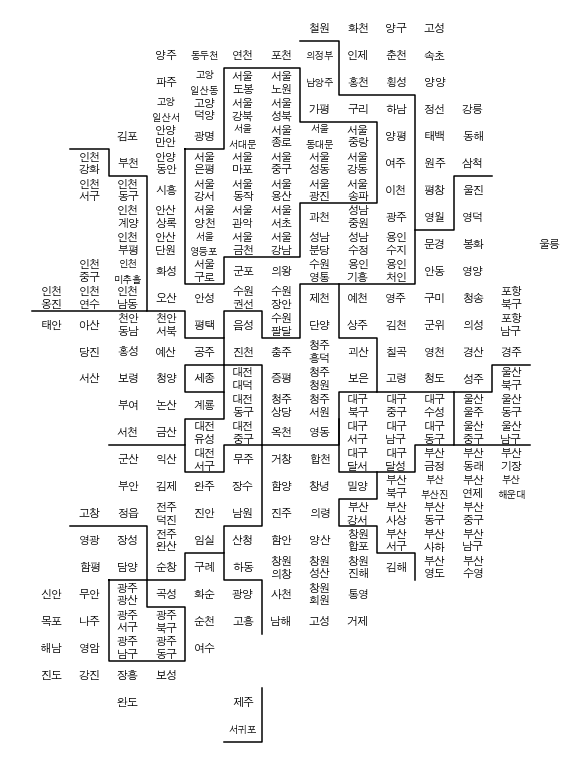

In [23]:
plt.figure(figsize=(8, 11))

# 지역 이름 표시
for idx, row in map_korea.iterrows():
    
    # 광역시는 구 이름이 겹치는 경우가 많아서 광역시 이름도 같이 표시 
    # (중구, 서구 등)
    if len(row.ID.split())==2:
        dispname = f'{row.ID.split()[0]}\n{row.ID.split()[1]}'
    elif row.ID[:2]=='고성':
        dispname = '고성'
    else:
        dispname = row.ID

    # 서대문구, 서귀포시 같이 이름이 3자 이상인 경우에 작은 글자로 표시
    if len(dispname.splitlines()[-1]) >= 3:
        fontsize, linespacing = 9.5, 1.5
    else:
        fontsize, linespacing = 11, 1.2

    plt.annotate(dispname, (row['x']+0.5, row['y']+0.5), weight='bold',
                 fontsize=fontsize, ha='center', va='center', 
                 linespacing=linespacing)
    
# 시도 경계
for path in BORDER_LINES:
    ys, xs = zip(*path)
    plt.plot(xs, ys, c='black', lw=1.5)

plt.gca().invert_yaxis()
#plt.gca().set_aspect(1)

plt.axis('off')

plt.tight_layout()
plt.show()

In [24]:
pop = pd.merge(pop, map_korea, how='left', on='ID')
pop.head()

광역시도  시군구  20~39세계  20~39세여자  65세이상계    인구수계   인구수남자   인구수여자      소멸비율  \
0   강원  강릉시    46008     20993   40497  203057  101154  101903  1.036768   
1   강원  고성군     4006      1699    7005   23621   11933   11688  0.485082   
2   강원  동해시    16311      7510   16152   83888   42093   41795  0.929916   
3   강원  삼척시    12428      5280   14953   61833   31630   30203  0.706213   
4   강원  속초시    15928      7411   14010   76302   37488   38814  1.057959   

   소멸위기지역      ID  y   x  
0   False      강릉  3  11  
1    True  고성(강원)  0  10  
2    True      동해  4  11  
3    True      삼척  5  11  
4   False      속초  1  10

In [25]:
pop.isnull().sum()

광역시도        0
시군구         0
20~39세계     0
20~39세여자    0
65세이상계      0
인구수계        0
인구수남자       0
인구수여자       0
소멸비율        0
소멸위기지역      0
ID          0
y           0
x           0
dtype: int64

In [26]:
pop.to_csv('./data/02.pop.csv', encoding='utf-8')

In [27]:
def drawKorea(targetData, blockedMap, cmapname):
    gamma = 0.75

    whitelabelmin = (max(blockedMap[targetData]) - 
                     min(blockedMap[targetData]))*0.25 + \
                     min(blockedMap[targetData])

    datalabel = targetData

    vmin = min(blockedMap[targetData])
    vmax = max(blockedMap[targetData])

    mapdata = blockedMap.pivot_table(index='y', columns='x', values=targetData)
    masked_mapdata = np.ma.masked_where(np.isnan(mapdata), mapdata)
    
    plt.figure(figsize=(9, 11))
    plt.pcolor(masked_mapdata, vmin=vmin, vmax=vmax, cmap=cmapname, 
               edgecolor='#aaaaaa', linewidth=0.5)

    # 지역 이름 표시
    for idx, row in blockedMap.iterrows():
        # 광역시는 구 이름이 겹치는 경우가 많아서 광역시 이름도 같이 표시 
        if len(row.ID.split())==2:
            dispname = f'{row.ID.split()[0]}\n{row.ID.split()[1]}'
        elif row.ID[:2]=='고성':
            dispname = '고성'
        else:
            dispname = row.ID

        # 서대문구, 서귀포시 같이 이름이 3자 이상인 경우에 작은 글자로 표시
        if len(dispname.splitlines()[-1]) >= 3:
            fontsize, linespacing = 10.0, 1.1
        else:
            fontsize, linespacing = 11, 1.

        annocolor = 'white' if row[targetData] > whitelabelmin else 'black'
        plt.annotate(dispname, (row['x']+0.5, row['y']+0.5), weight='bold',
                     fontsize=fontsize, ha='center', va='center', color=annocolor,
                     linespacing=linespacing)

    # 시도 경계 표시
    for path in BORDER_LINES:
        ys, xs = zip(*path)
        plt.plot(xs, ys, c='black', lw=2)

    plt.gca().invert_yaxis()

    plt.axis('off')

    cb = plt.colorbar(shrink=.1, aspect=10)
    cb.set_label(datalabel)

    plt.tight_layout()
    plt.show()

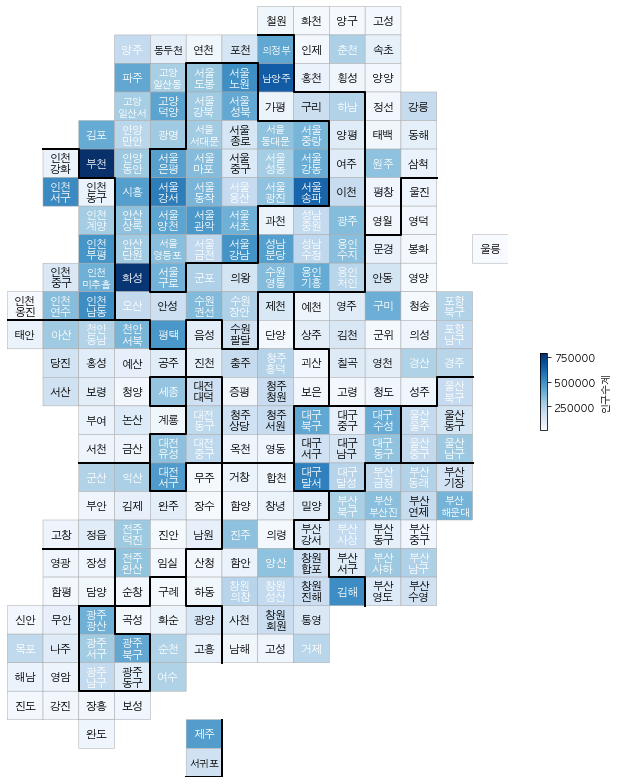

In [28]:
# 인구 현황 및 인구 소멸위기 지역 확인
drawKorea('인구수계', pop, 'Blues')

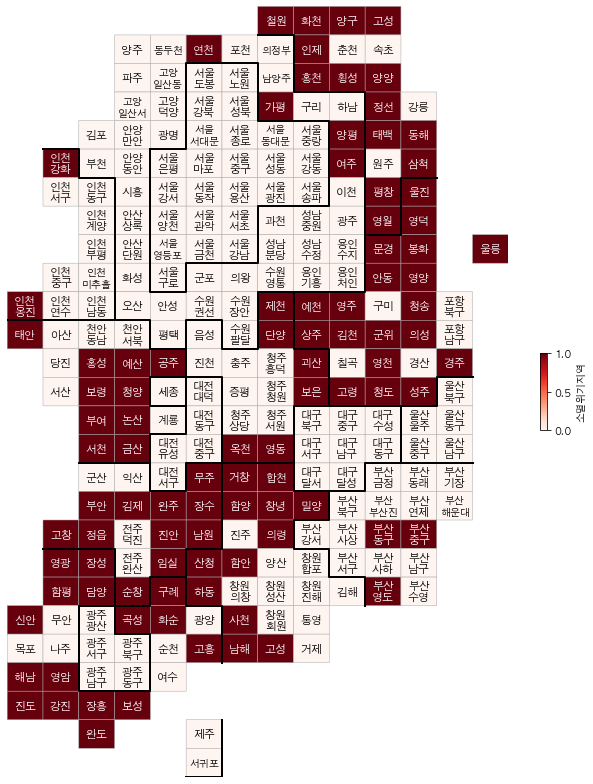

In [29]:
# 인구 소멸위기 지역
pop['소멸위기지역'] = [1 if con else 0 for con in pop['소멸위기지역']]
drawKorea('소멸위기지역', pop, 'Reds')

## 5-8 인구 현황에서 여성 인구 비율 확인하기

In [30]:
# 표현하고자 하는 값에 음수가 있을 경우 처리해주기 위해 약간 수정
def drawKoreaMinus(targetData, blockedMap, cmapname):
    gamma = 0.75

    whitelabelmin = 20.

    datalabel = targetData

    tmp_max = max([ np.abs(min(blockedMap[targetData])), 
                                  np.abs(max(blockedMap[targetData]))])
    vmin, vmax = -tmp_max, tmp_max

    mapdata = blockedMap.pivot_table(index='y', columns='x', values=targetData)
    masked_mapdata = np.ma.masked_where(np.isnan(mapdata), mapdata)
    
    plt.figure(figsize=(9, 11))
    plt.pcolor(masked_mapdata, vmin=vmin, vmax=vmax, cmap=cmapname, 
               edgecolor='#aaaaaa', linewidth=0.5)

    # 지역 이름 표시
    for idx, row in blockedMap.iterrows():
        # 광역시는 구 이름이 겹치는 경우가 많아서 광역시 이름도 같이 표시 
        if len(row.ID.split())==2:
            dispname = f'{row.ID.split()[0]}\n{row.ID.split()[1]}'
        elif row.ID[:2]=='고성':
            dispname = '고성'
        else:
            dispname = row.ID

        # 서대문구, 서귀포시 같이 이름이 3자 이상인 경우에 작은 글자로 표시한다.
        if len(dispname.splitlines()[-1]) >= 3:
            fontsize, linespacing = 10.0, 1.1
        else:
            fontsize, linespacing = 11, 1.

        annocolor = 'white' if np.abs(row[targetData]) > whitelabelmin else 'black'
        plt.annotate(dispname, (row['x']+0.5, row['y']+0.5), weight='bold',
                     fontsize=fontsize, ha='center', va='center', color=annocolor,
                     linespacing=linespacing)

    # 시도 경계 그린다.
    for path in BORDER_LINES:
        ys, xs = zip(*path)
        plt.plot(xs, ys, c='black', lw=2)

    plt.gca().invert_yaxis()

    plt.axis('off')

    cb = plt.colorbar(shrink=.1, aspect=10)
    cb.set_label(datalabel)

    plt.tight_layout()
    plt.show()

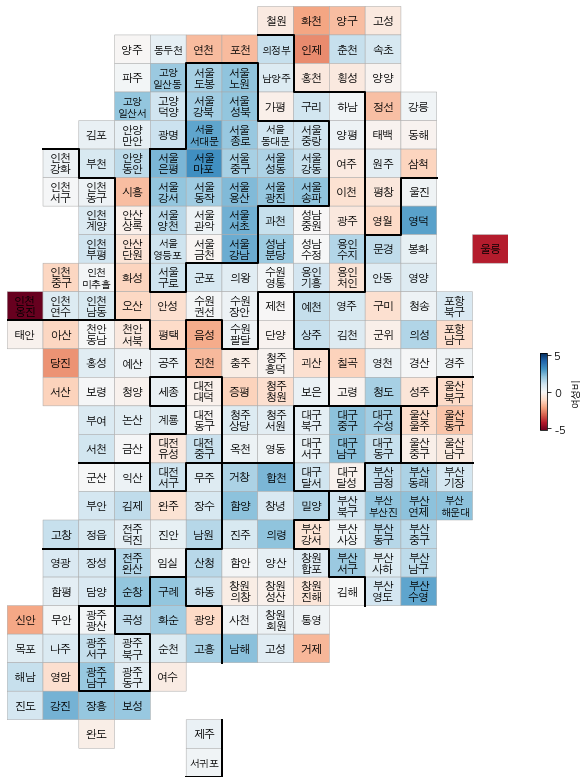

In [31]:
pop['여성비'] = (pop['인구수여자'] / pop['인구수계'] - 0.5) * 100
drawKoreaMinus('여성비', pop, 'RdBu')

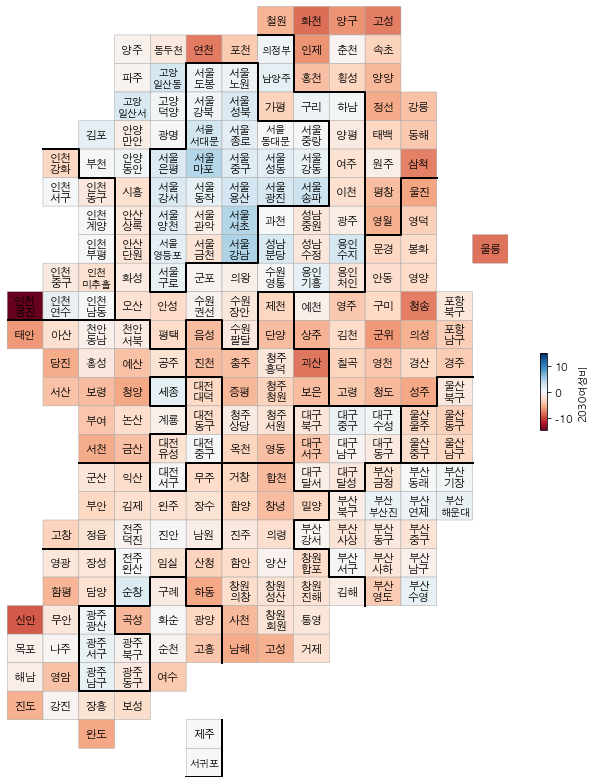

In [32]:
pop['2030여성비'] = (pop['20~39세여자'] / pop['20~39세계'] - 0.5) * 100
drawKoreaMinus('2030여성비', pop, 'RdBu')

In [33]:
pop.to_csv('./data/03.pop.csv', encoding='utf8')

## 5-9 Folium에서 인구 소멸 위기 지역 표현하기

In [34]:
import folium
import json
import warnings
warnings.simplefilter(action='ignore', category='FutureWarning')

In [24]:
pop.head()

광역시도  시군구  20~39세계  20~39세여자  65세이상계    인구수계   인구수남자   인구수여자      소멸비율  \
0   강원  강릉시    46008     20993   40497  203057  101154  101903  1.036768   
1   강원  고성군     4006      1699    7005   23621   11933   11688  0.485082   
2   강원  동해시    16311      7510   16152   83888   42093   41795  0.929916   
3   강원  삼척시    12428      5280   14953   61833   31630   30203  0.706213   
4   강원  속초시    15928      7411   14010   76302   37488   38814  1.057959   

   소멸위기지역      ID  
0   False      강릉  
1    True  고성(강원)  
2    True      동해  
3    True      삼척  
4   False      속초

In [25]:
pop_folium = pop.set_index('ID')
pop_folium.head()

광역시도  시군구  20~39세계  20~39세여자  65세이상계    인구수계   인구수남자   인구수여자      소멸비율  \
ID                                                                              
강릉       강원  강릉시    46008     20993   40497  203057  101154  101903  1.036768   
고성(강원)   강원  고성군     4006      1699    7005   23621   11933   11688  0.485082   
동해       강원  동해시    16311      7510   16152   83888   42093   41795  0.929916   
삼척       강원  삼척시    12428      5280   14953   61833   31630   30203  0.706213   
속초       강원  속초시    15928      7411   14010   76302   37488   38814  1.057959   

        소멸위기지역  
ID              
강릉       False  
고성(강원)    True  
동해        True  
삼척        True  
속초       False

In [26]:
geo_path = './data/skorea_municipalities_geo_simple.json'
geo_data = json.load(open(geo_path, encoding='utf8'))

m = folium.Map(location=[35.9902, 127.054], zoom_start=7)
folium.Choropleth(geo_data = geo_data,
               data = pop_folium['인구수계'],
               columns = [pop_folium.index, pop_folium['인구수계']],
               fill_color = 'YlGnBu',
               key_on = 'feature.id').add_to(m)
title_html = '<h3 align="center" style="font-size:20px"><b>기초자치단체별 인구수</b></h3>'   
m.get_root().html.add_child(folium.Element(title_html))
m

## 소멸위기 지역

In [27]:
m = folium.Map(location=[35.9902, 127.054], zoom_start=7)
folium.Choropleth(geo_data = geo_data,
               data = pop_folium['소멸위기지역'],
               columns = [pop_folium.index, pop_folium['소멸위기지역']],
               fill_color = 'PuRd',
               key_on = 'feature.id').add_to(m)
title_html = '<h3 align="center" style="font-size:20px"><b>소멸위기지역</b></h3>'   
m.get_root().html.add_child(folium.Element(title_html))
m